In [1]:
import os
os.getcwd()

'/Users/zhengyuanrui/Desktop/ensemble/script'

In [2]:
batch_size=32
epochs = 5

In [3]:
import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,TensorDataset
from torch import nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, accuracy_score
import torch.nn.functional as F
import tqdm
import math
from Model import *
from Myloader import *
from Training import *
import matplotlib.pyplot as plt


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
test_path = "../data/test"
val_path = "../data/validation"
train_path = "../data/train"

In [6]:
# transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

In [7]:
# test = datasets.ImageFolder(root=test_path, transform=transform) #, target_transform=lambda x: custom_target_transform(test.classes[x])
# test_loader = DataLoader(test, batch_size, shuffle=False)
# val = datasets.ImageFolder(root=val_path, transform=transform)
# val_loader = DataLoader(val, batch_size, shuffle=False)
# train = datasets.ImageFolder(root=train_path, transform=transform)
# train_loader = DataLoader(train, batch_size, shuffle=True)
# from Myloader import data_loader
train_dataloader, num_train = data_loader(train_path, batch_size, drop_last=False, shuffle=True)
val_dataloader, num_val = data_loader(val_path, batch_size, drop_last=False, shuffle=True)
test_dataloader, num_test = data_loader(test_path, batch_size, drop_last=False, shuffle=False)


Feature batch shape: torch.Size([32, 1, 56, 56])
Labels batch shape: torch.Size([32])


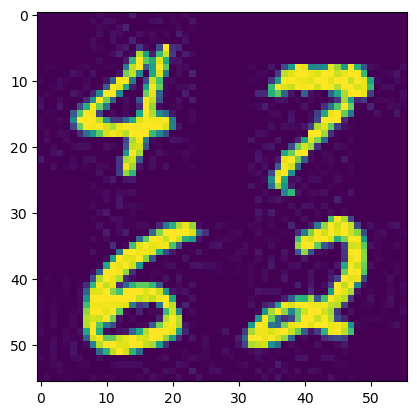

Label: 1


In [8]:
# Display image and label.
test_features, test_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[5].squeeze()
label = test_labels[5]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [9]:
model = MyResNet(dropout_prob=0.5).to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas = (0.9, 0.999))

In [11]:
train_loss, val_loss, val_acc, val_roc, model = model_training(epochs=5, model=model, train_loader=train_dataloader, val_loader=val_dataloader, optimizer=optimizer, device=device, loss_fun=F.binary_cross_entropy_with_logits)

Progress of epochs:  20%|██        | 1/5 [00:22<01:29, 22.43s/it]

Epoch [1/5], Train Loss: 0.3678, Val Loss: 0.6445, Val Acc: 0.7475, Val ROC AUC: 0.7405


Progress of epochs:  40%|████      | 2/5 [00:46<01:10, 23.57s/it]

Epoch [2/5], Train Loss: 0.1094, Val Loss: 0.1741, Val Acc: 0.9331, Val ROC AUC: 0.9312


Progress of epochs:  60%|██████    | 3/5 [01:10<00:47, 23.50s/it]

Epoch [3/5], Train Loss: 0.0644, Val Loss: 0.0492, Val Acc: 0.9832, Val ROC AUC: 0.9831


Progress of epochs:  80%|████████  | 4/5 [01:34<00:23, 23.97s/it]

Epoch [4/5], Train Loss: 0.0555, Val Loss: 0.0439, Val Acc: 0.9824, Val ROC AUC: 0.9826


Progress of epochs: 100%|██████████| 5/5 [01:57<00:00, 23.52s/it]

Epoch [5/5], Train Loss: 0.0440, Val Loss: 0.0563, Val Acc: 0.9824, Val ROC AUC: 0.9819
